In [1]:
!pip install allennlp
!pip install torch

import os
import sys
import json
import pickle
import random
import unicodedata
from tqdm import tqdm
from typing import Iterator, List, Dict
from collections import Counter, defaultdict
from itertools import combinations, permutations

# from method import getEntity

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import torch
from torch import optim
from allennlp.data.tokenizers import Token
from allennlp.data.fields import TextField, LabelField
from allennlp.data import Instance
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.models import Model
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.modules.seq2vec_encoders import PytorchSeq2VecWrapper, Seq2VecEncoder
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.data.vocabulary import Vocabulary
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.modules.token_embedders import Embedding
from allennlp.data.iterators import BucketIterator,BasicIterator
from allennlp.training.trainer import Trainer
from allennlp.predictors import SentenceTaggerPredictor

nltk.download('all')

     |████████████████████████████████| 5.4MB 8.9MB/s 
  Found existing installation: botocore 1.12.150
    Uninstalling botocore-1.12.150:
      Successfully uninstalled botocore-1.12.150


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

False

# Distribution

In [0]:
label_count = Counter()
evidence_count = Counter()
sentence_length_count = Counter()
with open('train_input.txt', 'rb') as t:
    train_input = pickle.load(t)
    for t in tqdm(train_input):
        label_count[t['label']] += 1
        evidence_count[len(t['evidence'])] += 1
#         for e in t['evidence']:
#             sentence_length_count[len([word for word in word_tokenize(wiki_dict[e[0]][str(e[1])])])] += 1
res = evidence_count.most_common()
sentence_res = sentence_length_count.most_common()
label_res = label_count.most_common()
res.sort()
sentence_res.sort()
label_res.sort()

100%|██████████| 145449/145449 [00:00<00:00, 851866.42it/s]


[('NOT ENOUGH INFO', 35639), ('REFUTES', 29775), ('SUPPORTS', 80035)]


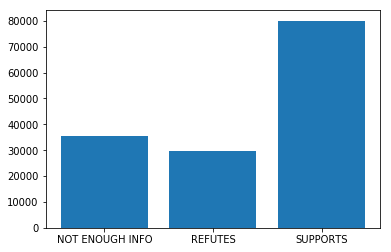

In [0]:
print(label_res)
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in label_res],[j for i,j in label_res])

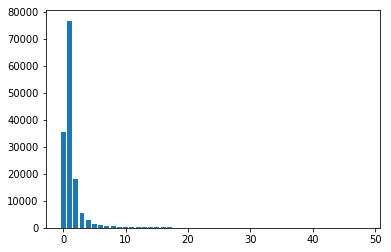

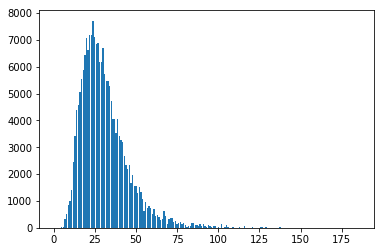

In [0]:
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in res],[j for i,j in res])
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in sentence_res],[j for i,j in sentence_res])

# Document Retrieval (Training Data)

In [0]:
input_path = 'Source/wiki-pages-text/'
wiki_dict = defaultdict(dict)

for i in tqdm(range(1, 110)):
    file_name = str(i).zfill(3)
    input_file = input_path + "wiki-" + file_name + '.txt'

    with open(input_file, 'r+') as wiki_file:
        for entry in wiki_file:
            entry = entry.split(' ')
            title = unicodedata.normalize('NFD', entry[0])
            label = unicodedata.normalize('NFD', entry[1])
            text = unicodedata.normalize('NFD', " ".join(entry[2:]))
            wiki_dict[title][label] = text

100%|██████████| 109/109 [01:52<00:00,  1.24it/s]


In [0]:
wiki_dict['Nikolaj_Coster-Waldau']['7']

'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .\n'

# Document Retrieval (Test Data)

In [0]:
res = {}
with open('Source/test-unlabelled.json') as test_file:
    t = json.load(test_file)
    for key in tqdm(t):
        alt = {}
        claim = t[key]['claim']
        alt['claim'] = claim
        alt['label'] = ""
        alt['evidence'] = []
        tokenized = nltk.word_tokenize(claim)
        l = nltk.pos_tag(tokenized)
        entity = getEntity(l)
        for e in entity:
            if e in wiki_dict:
                for k in wiki_dict[e]:
                    alt['evidence'].append([e, int(k), wiki_dict[e][k]])
        res[key] = alt
#         print(claim)
#         print(key)
#         print(res[key])

100%|██████████| 14997/14997 [00:11<00:00, 1315.79it/s]


In [0]:
res['73397']

{'claim': 'Temple of the Dog celebrated the 37th anniversary of their self-titled album.',
 'label': '',
 'evidence': [['Temple',
   0,
   'A temple -LRB- from the Latin word templum -RRB- is a structure reserved for religious or spiritual rituals and activities such as prayer and sacrifice .\n'],
  ['Temple',
   1,
   'It is typically used for such buildings belonging to all faiths where a more specific term such as church , mosque or synagogue is not generally used in English .\n'],
  ['Temple',
   2,
   'These include Hinduism , Buddhism , and Jainism among religions with many modern followers , as well as other ancient religions such as Ancient Egyptian religion .\n'],
  ['Temple',
   5,
   "The form and function of temples is thus very variable , though they are often considered by believers to be in some sense the `` house '' of one or more deities .\n"],
  ['Temple',
   6,
   'Typically offerings of some sort are made to the deity , and other rituals enacted , and a special grou

In [0]:
with open('text_result.json', 'w') as file:
    json.dump(res, file)

In [0]:
# Test Processing

In [0]:
test_claim = json.load(open('Source/test-unlabelled.json','r+'))
text_result = json.load(open('text_result.json','r+'))

result = {}
for key in tqdm(text_result):
    output = {}
    output['claim']=test_claim[key]['claim']
    output['string']=[]
    for evid_dict in text_result[key]:
        for evid_sent in evid_dict.values():
            output['string'].append(word_tokenize(evid_sent))
    result[key] = output
print(len(result))
with open('test_input.json','w+') as f :
    json.dump(result, f)
pickle.dump(result,open("test_input.txt",'wb'))

100%|██████████| 14997/14997 [00:46<00:00, 322.00it/s]


14997


# Read

In [0]:
with open('test_input.txt', 'rb') as test_file:
    result = pickle.load(test_file)

FileNotFoundError: ignored

In [0]:
for key in tqdm(result):
    l = len(result[key]['string'])
    result[key]['evidence'] = []
    for i in range(1, 4):
        result[key]['evidence'] += list(permutations([x for x in range(l)], i))

In [0]:
sys.getsizeof(result)

In [0]:
len(result)

In [0]:
j = 0
for key in tqdm(result):
    print(result[key])
    j += 1
    if j >= 2:
        break

  0%|          | 0/14997 [00:00<?, ?it/s]

{'evidence': [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (7, 10), (7, 11), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (8, 10), (8, 11), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 10), (9, 11), (10, 0), (10

In [0]:
json.dump(result, open('test.json', 'w'))
pickle.dump(result, open('test.txt', 'wb'))

KeyboardInterrupt: 

# DatasetReader

In [0]:
class VerbDatasetReader(DatasetReader):

    def __init__(self,sentence_indexers:Dict[str,TokenIndexer] = None)-> None:
        super().__init__(lazy=False)
        self.sentence_indexers=sentence_indexers or {"sentence":SingleIdTokenIndexer()}

    def text_to_instance(self, sentence:str ,labels:str = None)->Instance:
        sent_tokenized=[]
        for word in word_tokenize(sentence):
            sent_tokenized.append(Token(word))
#         print(sent_tokenized)
        sentence_field=TextField(sent_tokenized,self.sentence_indexers)
        fields={'sentence':sentence_field,'labels':LabelField(labels)}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        with open(file_path, 'rb') as f:
            train = pickle.load(f)
            pre = ""
            for value in train:
                claim = value['claim']
                if value['label'] == "NOT ENOUGH INFO":
                    continue
                    instance = claim + ' ' + pre
                    yield self.text_to_instance(instance, value['label'])
                else:
                    instance = claim
                    i = 0
                    for e in value['evidence']:
                        pre = ' '.join(e)
                        instance += ' '  + pre
                        i += 1
                        if i >= 3:
                            break
                    yield self.text_to_instance(instance, value['label'])

reader=VerbDatasetReader()
train_dataset=reader.read('train_input.txt')

random.shuffle(train_dataset)

validation_set = train_dataset[:3000]
train_set = train_dataset[3000:]

109810it [01:07, 1616.77it/s]


# Embedding

In [0]:
vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'), embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})

100%|██████████| 109810/109810 [00:05<00:00, 20103.74it/s]


# Lstm

In [0]:
class Lstm(Model):
    def __init__(self,
                 word_embeddings:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embeddings=word_embeddings
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()

    def forward(self,
                sentence:Dict[str,torch.Tensor],
                labels:torch.Tensor==None)->Dict[str,torch.Tensor]:
        mask=get_text_field_mask(sentence)
        embeddings = self.word_embeddings(sentence)
        encoder_out = self.encoder(embeddings, mask)
        tag_logits=self.hidden2tag(encoder_out)
        output = {"tag_logits": tag_logits}
        if labels is not None:
            self.accuracy(tag_logits, labels)
            loss=torch.nn.CrossEntropyLoss()
            output['loss'] = loss(tag_logits,labels)
        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

if torch.cuda.is_available():
    cuda_device = 0
    model = model.cuda(cuda_device)
else:
    cuda_device = -1

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_set,
                  validation_dataset=validation_set,
                  patience=10,
                  num_epochs=5,
                  cuda_device=cuda_device)

trainer.train()

accuracy: 0.7284, loss: 0.5852 ||: 100%|██████████| 3338/3338 [01:01<00:00, 53.93it/s]
accuracy: 0.7393, loss: 0.5728 ||: 100%|██████████| 94/94 [00:00<00:00, 109.07it/s]
accuracy: 0.7286, loss: 0.5843 ||: 100%|██████████| 3338/3338 [00:51<00:00, 65.11it/s]
accuracy: 0.7393, loss: 0.5768 ||: 100%|██████████| 94/94 [00:00<00:00, 139.70it/s]
accuracy: 0.7286, loss: 0.5830 ||: 100%|██████████| 3338/3338 [00:52<00:00, 63.75it/s]
accuracy: 0.7393, loss: 0.5725 ||: 100%|██████████| 94/94 [00:00<00:00, 149.95it/s]
accuracy: 0.7286, loss: 0.5816 ||: 100%|██████████| 3338/3338 [00:53<00:00, 62.73it/s]
accuracy: 0.7393, loss: 0.5741 ||: 100%|██████████| 94/94 [00:00<00:00, 151.84it/s]
accuracy: 0.7286, loss: 0.5815 ||: 100%|██████████| 3338/3338 [00:52<00:00, 64.22it/s]
accuracy: 0.7393, loss: 0.5730 ||: 100%|██████████| 94/94 [00:00<00:00, 148.13it/s]


{'best_epoch': 2,
 'best_validation_accuracy': 0.7393333333333333,
 'best_validation_loss': 0.5725382452315473,
 'epoch': 4,
 'peak_cpu_memory_MB': 4660.364,
 'peak_gpu_0_memory_MB': 1033,
 'training_accuracy': 0.7285553787098586,
 'training_cpu_memory_MB': 4660.364,
 'training_duration': '00:04:35',
 'training_epochs': 4,
 'training_gpu_0_memory_MB': 1033,
 'training_loss': 0.5814620591588474,
 'training_start_epoch': 0,
 'validation_accuracy': 0.7393333333333333,
 'validation_loss': 0.5729798703117573}

In [0]:
predictor = SentenceTaggerPredictor(model, dataset_reader=reader)
for i in range(1600, 2000):
    tag_logits = predictor.predict_instance(train_dataset[i])
    tag_ids = np.argmax(tag_logits, axis=-1)
    print(tag_ids)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [0]:
with open("test.th", 'wb') as f:
    torch.save(model.state_dict(), f)
    
vocab.save_to_files("vocabulary")

In [0]:
!brew install pylucene

import lucene

/bin/bash: brew: command not found


ModuleNotFoundError: ignored

In [0]:
from torch.nn import Dropout

train_input = pickle.load(open("mlinput_merge_with_entitiy.txt", 'rb'))
test = json.load(open('text_result.json', 'r+'))
idlist=[]

batch_accuracy=[]
batch_loss=[]

class ProjDataSetReader(DatasetReader):

    def __init__(self, sentence_indexers: Dict[str, TokenIndexer] = None) -> None:
        super().__init__(lazy=False)
        self.sentence_indexers = sentence_indexers or {"sentence": SingleIdTokenIndexer()}

    def text_to_instance(self, claim:str,evidence:List[str],label:str=None)->Instance:
        tobeField=[]
        for claim_word in claim.split(' '):
            tobeField.append(Token(claim_word))
        claim_field=TextField(tobeField,self.sentence_indexers)
        tobeField=[]
        for evidence_sent in evidence:
            for evidence_word in evidence_sent.split(' '):
                tobeField.append(Token(evidence_word))
        evidence_field=TextField(tobeField,self.sentence_indexers)
        if label!=None:
            fields={'claim':claim_field,'evidence':evidence_field,'label':LabelField(label)}
        else:
            fields={'claim':claim_field,'evidence':evidence_field}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        if file_path=="train":
            pre = ""
            for value in train_input:
                claim = value['claim']
                if 'label' in value:
                    label = value['label']
                else:
                    label=None
                if label == "NOT ENOUGH INFO":
                #                     continue
                #instance = claim + ' ' + pre
                    evidence=[pre]
                    yield self.text_to_instance(claim,evidence,label)
                else:
                    i = 0
                    full_evidence=[]
                    for e in value['evidence']:
                        pre = ' '.join(e)
                    #instance += ' ' + pre
                        full_evidence.append(pre)
                        i += 1
                        if i >= 3:
                            break
                    yield self.text_to_instance(claim,full_evidence,label)
        elif file_path=='test':
            for id in test:
                idlist.append(id)
                claim=test[id]['claim']
                evidence=test[id]['evidence']
                if len(evidence)>0:
                    i=0
                    full_evidence=[]
                    for e in evidence:
                        full_evidence.append(e[2])
                        i+=1
                        if i>=3:
                            break
                else:
                     full_evidence=[]
                yield self.text_to_instance(claim,full_evidence)

class Lstm(Model):
    def __init__(self,
                 word_embedding:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embedding=word_embedding
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()
        self.m = Dropout(p=0.2)

    def forward(self,
                claim:Dict[str,torch.Tensor],
                evidence:Dict[str,torch.Tensor],
                label=None)->Dict[str,torch.Tensor]:
        claim_mask=get_text_field_mask(claim)
        claim_embedding=self.word_embedding(claim)
        claim_encoder_out=self.encoder(claim_embedding,claim_mask)
        claim_tag_logits=self.hidden2tag(claim_encoder_out)
        evidence_mask=get_text_field_mask(evidence)
        evidence_embedding=self.word_embedding(evidence)
        evidence_encoder_out=self.encoder(evidence_embedding,evidence_mask)
        evidence_tag_logits=self.hidden2tag(evidence_encoder_out)
        tag_logits=claim_tag_logits+evidence_tag_logits
        tag_logits=self.m(tag_logits)
        
        output={'tag_logits':tag_logits}
        if label is not None:
            self.accuracy(tag_logits,label)
            loss=torch.nn.CrossEntropyLoss()
            output['loss']=loss(tag_logits,label)
            batch_loss.append(float(output['loss']))
            batch_accuracy.append(self.accuracy.get_metric())
        return output

    def get_metrics(self, reset: bool = False)->Dict[str,float]:
        return {'accuracy':self.accuracy.get_metric(reset)}

reader=ProjDataSetReader()

print("start reading data")
train_dataset=reader.read('train')
print("data reading finished")

vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                            embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})
lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

# if torch.cuda.is_available():
#     cuda_device = 0
#     model = model.cuda(cuda_device)
# else:
#     cuda_device = -1

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_dataset[1000:],
                  validation_dataset=train_dataset[:1000],
                  patience=3,
                  num_epochs=100)
#                   cuda_device=cuda_device)
print("start training model")
trainer.train()
print("training finished")

# print(batch_accuracy)
# print(batch_loss)


1471it [00:00, 14705.11it/s]

start reading data


145449it [00:21, 6899.90it/s]
  2%|▏         | 2669/145449 [00:00<00:05, 26686.84it/s]

data reading finished


  0%|          | 0/4515 [00:00<?, ?it/s]

start training model


accuracy: 0.7520, loss: 0.5531 ||: 100%|██████████| 4515/4515 [20:03<00:00,  4.48it/s]
accuracy: 0.8580, loss: 0.3299 ||: 100%|██████████| 32/32 [00:00<00:00, 53.40it/s]
accuracy: 0.8278, loss: 0.3808 ||: 100%|██████████| 4515/4515 [20:13<00:00,  4.22it/s]
accuracy: 0.8710, loss: 0.3426 ||: 100%|██████████| 32/32 [00:00<00:00, 58.48it/s]
accuracy: 0.8417, loss: 0.3328 ||:   2%|▏         | 105/4515 [00:28<20:21,  3.61it/s]

In [0]:
len(batch_accuracy)

31829

In [0]:
batch_loss

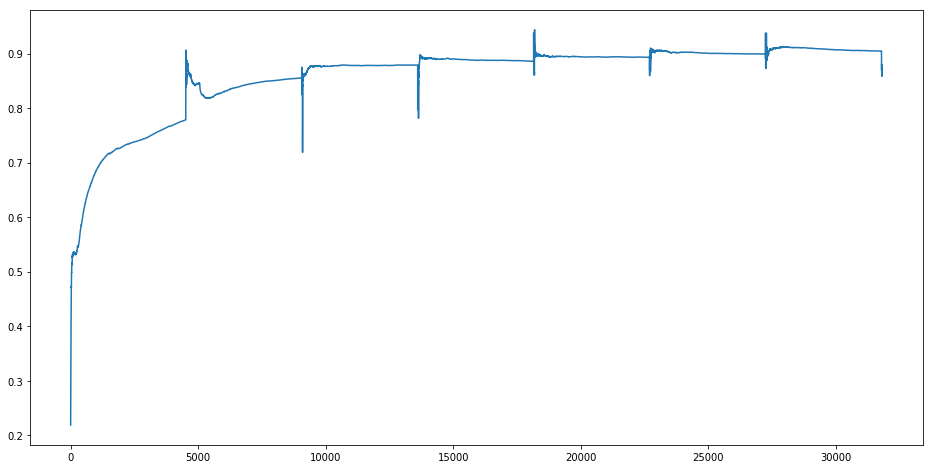

In [0]:
x = [i for i in range(1, len(batch_accuracy) + 1)]
plt.figure(figsize=(16,8))
plt.plot(x, batch_accuracy)

In [0]:
print("start reading test dataset")
test_dataset=reader.read('test')
print("reading finished")


2279it [00:00, 11144.55it/s]

start reading test dataset


14997it [00:03, 3862.97it/s]

reading finished


In [0]:

batch_generator = iterator(test_dataset, num_epochs=1, shuffle=False)
model.eval()
softmax=torch.nn.Softmax()

print("starting predict")
with torch.no_grad():
    i=0
    for batch in batch_generator:
        logits = model(**batch)
        ids = softmax(torch.FloatTensor(logits['tag_logits']))
        maxid = np.argmax(ids,axis=1)
        j=0
        for id in maxid:
            if len(test[idlist[j+i*32]]['evidence'])!=0:
                if int(id)==0:
                    test[idlist[j+i*32]]['label']="SUPPORTS"
                elif int(id)==1:
                    test[idlist[j+i*32]]['label']="REFUTES"
                elif int(id)==2:
                    test[idlist[j+i*32]]['label']="NOT ENOUGH INFO"


            else:
                test[idlist[j + i * 32]]['label'] = "NOT ENOUGH INFO"
            if test[idlist[j + i * 32]]['label'] == "NOT ENOUGH INFO":
                test[idlist[j + i * 32]]['evidence'] = []
            else:
                for entry in test[idlist[j + i * 32]]['evidence']:
                    entry.pop(2)
            '''
            place the evidence here
            '''
            j+=1
        i+=1



with open('answer3.0.json','w+') as f:
    json.dump(test,f)


starting predict


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
